In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

import seaborn as sns
import datetime

In [2]:
rosbank_train = pd.read_csv('rosbank_train.csv')
rosbank_train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [27]:
rosbank_train_x = rosbank_train[rosbank_train.target_flag == 1]
rosbank_train_x.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
109,01/06/2017,5,5944,NaN,810,18JUN17:00:00:00,3719.00,POS,1,326211.75
110,01/06/2017,5,6012,NaN,810,14JUN17:00:00:00,10000.00,C2C_OUT,1,326211.75
111,01/04/2017,5,5621,NaN,810,06APR17:00:00:00,1399.00,POS,1,326211.75
112,01/06/2017,5,5691,NaN,810,17JUN17:00:00:00,3190.00,POS,1,326211.75
113,01/04/2017,5,5499,NaN,810,25APR17:00:00:00,1387.61,POS,1,326211.75


In [28]:
rosbank_train['MCC'].value_counts().head(5)

5411    75343
6011    35524
5814    30285
5812    21741
5499    17913
Name: MCC, dtype: int64

Топ 5 самых популярных МСС:
    - Бакалейные магазины, супермаркеты (5411)
    - Финансовые учреждения – снятие наличности автоматически (6011)
    - Фастфуд (5814)
    - Места общественного питания, рестораны (5812)
    - Различные продовольственные магазины (5499)
Таким образом можно отметить, что самые популярные транзакции так, или  иначе связаны с питанием (покупка продуктов, 
заведения общественного питания), либо со снятием наличных в банкоматах.

In [34]:
rosbank_train['trx_category'].value_counts().head(5)

POS               416425
DEPOSIT            21216
WD_ATM_ROS         19104
WD_ATM_PARTNER      9948
C2C_IN              7306
Name: trx_category, dtype: int64

Самый популярый способ оплаты - оплата бановской картой через POS-терминал

In [40]:
def transaction_by_day_count(rosbank_train):
    rosbank_train['day_of_transaction'] = rosbank_train['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = rosbank_train.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in rosbank_train['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
day_count = transaction_by_day_count(rosbank_train)
day_count.head()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0


In [52]:
for column in day_count:
    print(day_count[column].sum())

25561672
62114.0
65927.0
68509.0
69485.0
71458.0
78993.0
74027.0


Чаще всего клиенты совершают покупки в конце недели и в выходные (наиболее популярный день - воскресенье), что не удивительно, 
ведь именнно в выходные семьи едут закупаться продуктами на предстоящую неделю

In [5]:
def transaction_by_hour_count(rosbank_train):
    rosbank_train['hour_of_transaction'] = rosbank_train['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return rosbank_train.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()
hour_count = transaction_by_hour_count(rosbank_train)
hour_count.head()

hour_of_transaction,cl_id,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,7.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,299.0,3.0,6.0,8.0,14.0,9.0,19.0,17.0,13.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [12]:
for column in hour_count:
    print(hour_count[column].sum())

25561672
432913.0
252.0
350.0
456.0
660.0
981.0
1315.0
1983.0
2699.0
3635.0
4088.0
4681.0
4707.0
4843.0
4397.0
4120.0
3848.0
3816.0
3659.0
2704.0
1797.0
1268.0
850.0
491.0


Наибольшее количество транзакций проходит с 10 до 14 (максимум - с 13 до 14). В рабочие дни в пикоыве часы как раз перерыв на обед, в выходные - люди выспались и идут за покупками.

Посмотрим распределние данных

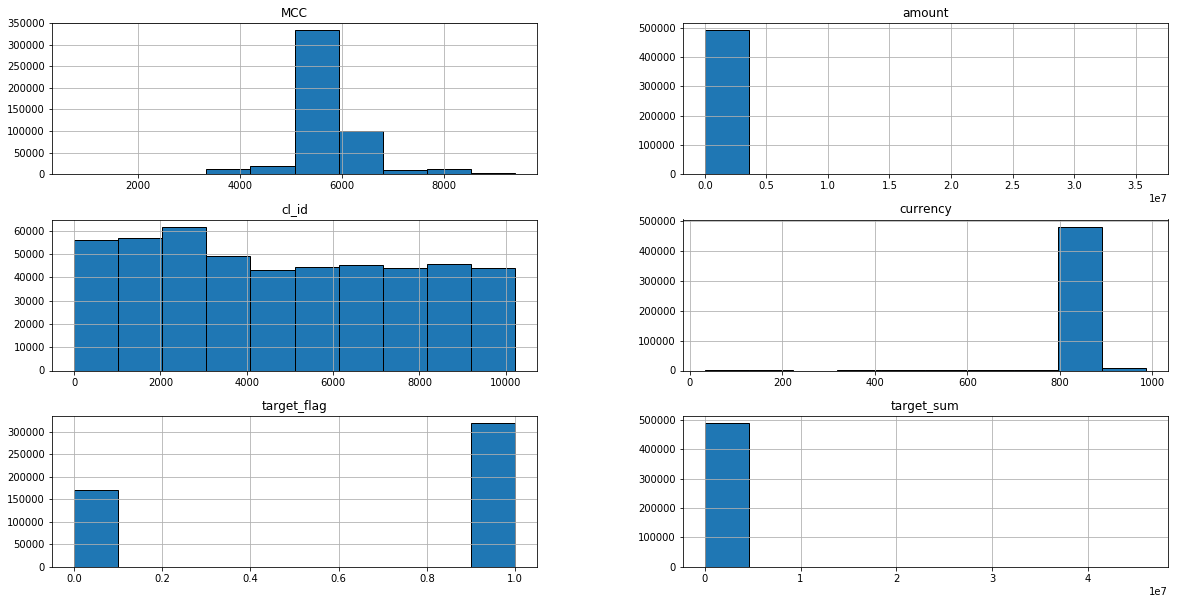

In [19]:
rosbank_train.hist(edgecolor='black', linewidth=1.0)
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

Сумма и количество операций по каждому клиенту

In [38]:
train_group_trx = rosbank_train[
    ['cl_id', 'amount', 'trx_category']
].groupby(['cl_id', 'trx_category']).agg(['sum', 'count'])
train_group_trx.head()

amount      
                          sum count
cl_id trx_category                 
0     C2C_OUT        36562.00     1
      DEPOSIT        20000.00     1
      POS             7821.00     3
1     DEPOSIT        95000.00     2
      POS           122578.04   101

Сумма и количество использований денежных средст каждого клиента в рахных торговых точках

In [39]:
train_group_MCC = rosbank_train[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC']).agg(['sum', 'count'])
train_group_MCC.head()

amount      
                sum count
cl_id MCC                
0     5200   5023.0     1
      5411   2031.0     1
      5921    767.0     1
      6011  20000.0     1
      6012  36562.0     1